# KA User Survey Analysis
_Ravi Dayabhai_ (**@ravi**)

In [39]:
# Import dependencies
import datetime as dt
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import re
%matplotlib inline

# Show all columns
pd.set_option('display.max_columns', None)

## Entrance Survey
According to TomP:
>About 3 years ago I started a quick survey showing to a small % of users, asking how they heard about KA. It was useful data for marketing efforts at the time. We decided to keep it running, assuming the mix changed throughout the school year, and over time in general.
>
>I've attached the raw results of the survey. (It hasn't always run consistently, but it doesn't change that much over time. I noticed someone had turned it off at some point in the last 12 months, so I restarted it recently to have up-to-date results). 

First, getting a sense of the data.

In [40]:
# Open files
rolling_entrance = pd.read_csv("KA Entrance Survey Rolling (June 2017).csv", low_memory=False, index_col=None)

# Check column types
rolling_entrance.dtypes

Response ID                                                                                     int64  
Date                                                                                            object 
Identity                                                                                        object 
IP Address                                                                                      object 
Page                                                                                            object 
Referrer                                                                                        float64
User Agent                                                                                      object 
bibliotron_new_design                                                                           object 
window_width                                                                                    float64
window_height                                                   

In [41]:
rolling_entrance.shape

(92741, 26)

Making sure the primary key consists of unique values.

In [42]:
if len(rolling_entrance["Response ID"]) == len(rolling_entrance["Response ID"].unique()):
    print("All values in column are unique!")
else:
    print("There are duplicate or missing data in column.")

All values in column are unique!


Then, checking the nulls in each column.

In [43]:
rolling_entrance.isnull().sum()

Response ID                                                                                     0    
Date                                                                                            0    
Identity                                                                                        0    
IP Address                                                                                      0    
Page                                                                                            0    
Referrer                                                                                        92741
User Agent                                                                                      0    
bibliotron_new_design                                                                           67284
window_width                                                                                    67206
window_height                                                                     

In [44]:
cols_of_interest = ["Q1: Would you tell a friend to use Khan Academy?", "Q2: I am a ....", "Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?"]
rolling_entrance[cols_of_interest].isnull().all(axis=1).sum()

0

From above it's clear that there are no rows where the responses to all of the survey questions are null. I'm a little confused how 140 rows don't have a response for "Q1." Given that this is the primary question we're interested in, any responses with null values for this question are dropped.

In [45]:
rolling_entrance = rolling_entrance[rolling_entrance["Q1: Would you tell a friend to use Khan Academy?"].notnull()]
rolling_entrance.shape

(92601, 26)

Next, converting the "Date" column to a DateTime type.

In [46]:
# Ignore 'SettingWithCopyWarning'
pd.options.mode.chained_assignment = None

rolling_entrance.loc[:,"Date"] = pd.to_datetime(rolling_entrance["Date"])
rolling_entrance.dtypes

Response ID                                                                                     int64         
Date                                                                                            datetime64[ns]
Identity                                                                                        object        
IP Address                                                                                      object        
Page                                                                                            object        
Referrer                                                                                        float64       
User Agent                                                                                      object        
bibliotron_new_design                                                                           object        
window_width                                                                                    float64       
w

Looking at the range of dates.

In [47]:
rolling_entrance.Date.describe()

count     92601              
unique    91510              
top       2017-04-28 15:49:52
freq      4                  
first     2016-02-09 18:50:28
last      2017-06-13 08:53:42
Name: Date, dtype: object

Determining distribution of responses by month in the date range.

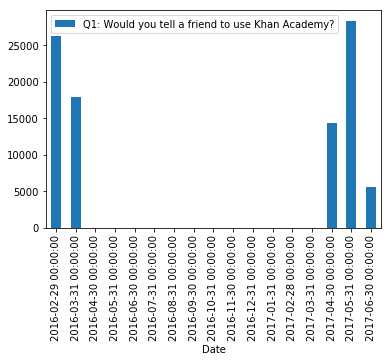

In [48]:
# Count responses per month
rolling_entrance.reset_index("Date", inplace=True)
date_df = rolling_entrance.set_index("Date")
date_responses_data = date_df[["Q1: Would you tell a friend to use Khan Academy?"]].groupby(pd.TimeGrouper(freq='M')).count()

# Plot histogram of responses
date_responses_data.plot.bar()

In [49]:
date_responses_data

,Q1: Would you tell a friend to use Khan Academy?
Date,
2016-02-29,26333
2016-03-31,17957
2016-04-30,1
2016-05-31,0
2016-06-30,0
2016-07-31,0
2016-08-31,0
2016-09-30,0
2016-10-31,0


Looks like we figured out when this was turned off! Checking to see that IP addresses are unique (i.e., we don't have multiple responses from the same IP address).

In [50]:
set(rolling_entrance["IP Address"]) == rolling_entrance.shape[0]

False

In [51]:
# Duplicate IPs
duplicate_IP = rolling_entrance[rolling_entrance["IP Address"].duplicated(keep=False)].sort_values(["IP Address"])
duplicate_IP_display = duplicate_IP.groupby(["IP Address"]).count().loc[:,["Response ID", "Q1: Would you tell a friend to use Khan Academy?"]].rename(columns={"Response ID": "# of Responses", "Q1: Would you tell a friend to use Khan Academy?": "# answered Q1"})
duplicate_IP_display

,# of Responses,# answered Q1
IP Address,,
1.179.181.178,2,2
1.240.0.117,14,14
100.0.207.66,2,2
100.1.18.214,2,2
100.12.169.66,5,5
100.32.137.123,2,2
100.33.235.229,6,6
100.35.38.10,2,2
100.36.204.94,2,2


So, there are **8602 IP addresses that have submitted a response more than once**. Checking below to see if there are any duplicates for "Date - IP Address" pairs. The following looks at a couple of the outliers from these duplicates.

In [52]:
funky_IP = duplicate_IP[duplicate_IP["IP Address"] == "1.240.0.117"]
funky_IP.iloc[:,23:]

,Q1: Would you tell a friend to use Khan Academy?,Q2: I am a ....,Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?,Q3. Other explain
58736,No,Teacher,NaN,NaN
58710,Yes!,Learner/student,No,NaN
58711,No,Learner/student,No,NaN
58712,No,Teacher,NaN,NaN
58713,No,Teacher,NaN,NaN
58718,No,Teacher,NaN,NaN
58739,No,Teacher,NaN,NaN
58709,No,Teacher,NaN,NaN
58735,Yes!,Learner/student,No,NaN
58704,No,Teacher,NaN,NaN


In [53]:
rolling_entrance[rolling_entrance.duplicated(subset=["Date", "IP Address"], keep=False)]

,index,Response ID,Date,Identity,IP Address,Page,Referrer,User Agent,bibliotron_new_design,window_width,window_height,eligible_for_nps_survey,eligible_for_sat_intent_survey_1,eligible_for_sat_satisfaction_survey,eligible_for_unregistered_user_goal_survey,eligible_for_sat_intent_survey_2,eligible_for_registered_user_goal_survey,view_project_failure,bibliotron_homepage,article_satisfaction_survey,view_project_completed,submitted_project,submitted_project_eval,Q1: Would you tell a friend to use Khan Academy?,Q2: I am a ....,Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?,Q3. Other explain
29697,29750,75571785,2016-03-03 14:25:45,_gae_bingo_random:GUAqmAw-3odcVYbWCJfCQN02_hr1Si6hVl9Ss5R6,98.100.200.205,https://www.khanacademy.org/mission/cc-sixth-grade-math/task/5435783873953792,NaN,"Mozilla/5.0 (X11; CrOS armv7l 7647.84.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.116 Safari/537.36",NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes!,Learner/student,"Yes ,No",NaN
29760,29813,75573854,2016-03-03 14:25:45,_gae_bingo_random:EcirqdVCEicfyMeUIC74PV_wqUPP6Cs6pd46v4BL,98.100.200.205,https://www.khanacademy.org/mission/cc-fifth-grade-math/task/4921177958252544,NaN,"Mozilla/5.0 (X11; CrOS armv7l 7647.84.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.116 Safari/537.36",NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Maybe / not sure,Learner/student,Yes,NaN


This is sort of weird. We have a 2 responses by the _exact same IP address_ at the _exact same time_ with different answers to the survey questions.

Note: the following NPS calculations don't make adjustments for these. While these may skew the results, they are a relatively small subset of the overall responses and I didn't bother dealing with these before undergoing the subsequent analysis.

### NPS Scores

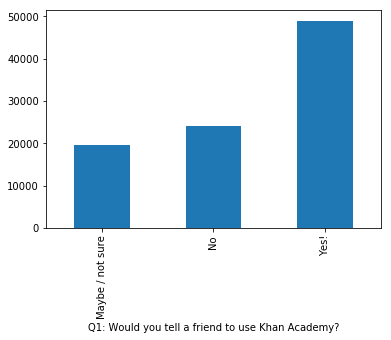

In [54]:
# Create Q1 Series
Q1_dist = rolling_entrance.groupby(["Q1: Would you tell a friend to use Khan Academy?"]).count()["Response ID"]

# Plot distribution of responses to Q1
Q1_dist.plot.bar()

#### NPS (Overall)

Below constructs the NPS breakdown by user type for the entirety of the dataset.

In [55]:
# Creates NPS value field mapped to each response to Q1
mapping = {'Maybe / not sure': 0, 'No': -1, 'Yes!': 1}
rolling_entrance["NPS_vals"] = rolling_entrance["Q1: Would you tell a friend to use Khan Academy?"].apply(lambda x: mapping[x] * 100)

# Check NPS value field for nulls
rolling_entrance["NPS_vals"].isnull().sum()

0

In [56]:
rolling_entrance[["NPS_vals","Q1: Would you tell a friend to use Khan Academy?"]].isnull().any(axis=0)

NPS_vals                                            False
Q1: Would you tell a friend to use Khan Academy?    False
dtype: bool

In [57]:
# Groups the NPS scores by respondent type
NPS_results_all = rolling_entrance.groupby(["Q2: I am a ...."]).agg({"Response ID": 'size', "NPS_vals": 'mean'}).rename(columns={"Response ID": '# of Responses','NPS_vals': 'NPS'}).reset_index()
NPS_results_all.sort_values("NPS", ascending=False)

,Q2: I am a ....,# of Responses,NPS
2,"Parent ,Learner/student",232,70.258621
4,"Teacher ,Learner/student",165,63.030303
5,"Teacher ,Parent",72,36.111111
0,Learner/student,64296,35.283688
1,Parent,2982,25.050302
3,Teacher,4245,17.926973
6,"Teacher ,Parent ,Learner/student",291,6.872852


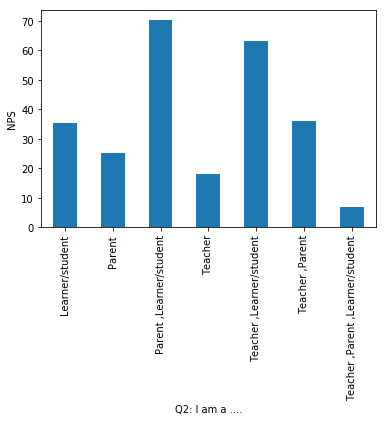

In [58]:
NPS_results_all.set_index(["Q2: I am a ...."]).NPS.plot.bar().set_ylabel("NPS")

#### NPS (per Wave)

Performing the same analysis, but dividing the time series into two distinct groups (responses before May 2016 and after March 2017).

In [59]:
# Set cut-off date: May 1, 2016
cut_off = dt.datetime(2016, 5, 1)

# Divide the data
wave_1 = rolling_entrance[rolling_entrance["Date"] < cut_off]
wave_2 = rolling_entrance[rolling_entrance["Date"] > cut_off]

# Do NPS grouping by respondent type
NPS_results_wave_1 = wave_1.groupby(["Q2: I am a ...."]).agg({"Response ID": 'size', "NPS_vals": 'mean'}).rename(columns={"Response ID": '# of Responses','NPS_vals': 'NPS'}).reset_index()
NPS_results_wave_2 = wave_2.groupby(["Q2: I am a ...."]).agg({"Response ID": 'size', "NPS_vals": 'mean'}).rename(columns={"Response ID": '# of Responses','NPS_vals': 'NPS'}).reset_index()

Wave 1 (basically early 2016):

In [60]:
NPS_results_wave_1.sort_values("NPS", ascending=False)

,Q2: I am a ....,# of Responses,NPS
2,"Parent ,Learner/student",232,70.258621
4,"Teacher ,Learner/student",165,63.030303
1,Parent,904,41.371681
0,Learner/student,26376,39.653473
5,"Teacher ,Parent",72,36.111111
3,Teacher,1452,27.548209
6,"Teacher ,Parent ,Learner/student",291,6.872852


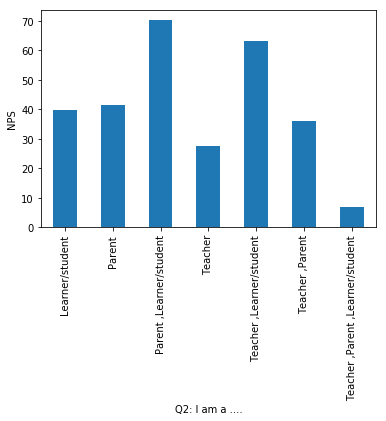

In [61]:
NPS_results_wave_1.set_index(["Q2: I am a ...."]).NPS.plot.bar().set_ylabel("NPS")

Wave 2 (basically 2Q17):

In [62]:
NPS_results_wave_2.sort_values("NPS", ascending=False)

,Q2: I am a ....,# of Responses,NPS
0,Learner/student,37920,32.244198
1,Parent,2078,17.949952
2,Teacher,2793,12.925170


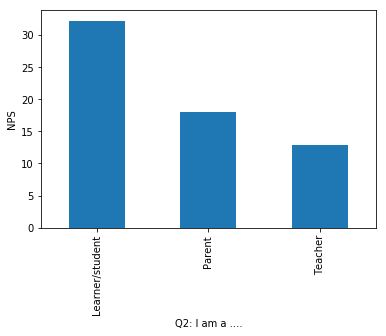

In [63]:
NPS_results_wave_2.set_index(["Q2: I am a ...."]).NPS.plot.bar().set_ylabel("NPS")

Comparing Wave 1 vs. Wave 2, joining just (from Wave 1) those who only self-identified as one type of respondent.

In [64]:
# Set indexes before joining Wave 1 results table with Wave 2 results table
NPS_results_wave_1.set_index(["Q2: I am a ...."], inplace=True)
NPS_results_wave_2.set_index(["Q2: I am a ...."], inplace=True)

# Join dataframes on respondent type
NPS_over_time = NPS_results_wave_1.join(NPS_results_wave_2, how="right", rsuffix=" (Wave 2)", lsuffix=" (Wave 1)")
NPS_over_time

,# of Responses (Wave 1),NPS (Wave 1),# of Responses (Wave 2),NPS (Wave 2)
Q2: I am a ....,,,,
Learner/student,26376,39.653473,37920,32.244198
Parent,904,41.371681,2078,17.949952
Teacher,1452,27.548209,2793,12.925170


#### NPS (by Strict Category)
Here I'm ignoring responses that are compound type (i.e., only looking at responses that are "Parent", "Teacher", xor "Learner/student").

In [65]:
# Filters respondent type strictly
strict_cond = rolling_entrance["Q2: I am a ...."].isin(["Parent", "Teacher", "Learner/student"])

# Groups the NPS scores by respondent type
NPS_results_strict = rolling_entrance[strict_cond].groupby(["Q2: I am a ...."]).agg({"Response ID": 'size', "NPS_vals": 'mean'}).rename(columns={"Response ID": '# of Responses','NPS_vals': 'NPS'}).reset_index()
NPS_results_strict.sort_values("NPS", ascending=False)

,Q2: I am a ....,# of Responses,NPS
0,Learner/student,64296,35.283688
1,Parent,2982,25.050302
2,Teacher,4245,17.926973


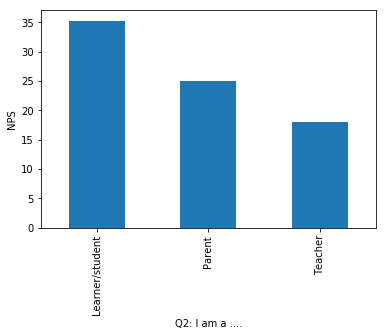

In [66]:
NPS_results_strict.set_index(["Q2: I am a ...."]).NPS.plot.bar().set_ylabel("NPS")

### NPS Commentary

See below for **all of the commentary** provided by survey respondents.

In [67]:
# Show strings in full and show all rows
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

# Select respondent type, response, and NPS value
commentary_condition = rolling_entrance["Q3. Other explain"].notnull()
rolling_entrance[commentary_condition].loc[:,["Q2: I am a ....", "Q3. Other explain", "Q1: Would you tell a friend to use Khan Academy?"]]

,Q2: I am a ....,Q3. Other explain,Q1: Would you tell a friend to use Khan Academy?
44305,Learner/student,fuck,Yes!
44315,Learner/student,self learning,Yes!
44353,Learner/student,my dad wants me to (i know i am not using correct grammar)i was sometimes self encouraged,Maybe / not sure
44363,Learner/student,Studying for test,Yes!
44369,Learner/student,I'm learning about new subjects,Yes!
44424,Learner/student,homeschool,Yes!
44446,Learner/student,MCAT,Yes!
44583,Learner/student,i just love to learn that's why im here,Yes!
44585,Learner/student,im trying to improve on my math,Maybe / not sure
44591,Learner/student,exams,Yes!


See below for **detractors commentary**.

In [68]:
detract_comment_cond = (rolling_entrance["Q3. Other explain"].notnull() & (rolling_entrance["NPS_vals"] < 0))
detractors = rolling_entrance[detract_comment_cond].loc[:,["Q2: I am a ....", "Q3. Other explain", "Q1: Would you tell a friend to use Khan Academy?"]]
detractors

,Q2: I am a ....,Q3. Other explain,Q1: Would you tell a friend to use Khan Academy?
45256,Learner/student,School work. Love how switching to this has also made a rise in blood pressure,No
45488,Learner/student,working,No
45572,Learner/student,"My father wants me not to be dumb so I'm trying this out but it's really hard. When I see that grey X indicating I answered a question incorrectly it really makes me feel bad. Then I answer another one and I get i wrong as well. No offense to whoever is reading this, but I hate Khan Academy. It just proves how stupid and insecure I am and that there is nothing I can do to avert that.",No
45742,Learner/student,Blackmail,No
45916,Learner/student,other stuff to do,No
46202,Learner/student,parents,No
46442,Learner/student,no and leave me alone,No
46804,Learner/student,My mother wants me on this website fo 30 minutes!,No
46985,Learner/student,Assigned work and avid interest,No
47382,Learner/student,"yes, and it is fun, I thought this was an ad that's why I said no so if it's not an ad then yes for the first question!",No


In [69]:
# Turn off show all rows
pd.set_option('display.max_rows', 25)

#### Aside: NPS for Self-Identified C&CL Learners
Here I'm using self-identification of respondent type to estimate the NPS for "C&CL" learners. This is to quickly (read: crudely) show that C&CL learners in general have a lower NPS (e.g., arising from forced usage).

In [70]:
# Choose only learners
learners_only = rolling_entrance[rolling_entrance["Q2: I am a ...."] == "Learner/student"]

# Group by response to Q3 as proxy for learner type
learner_type_table = learners_only.groupby(["Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?"]).agg({"Response ID": 'size', "NPS_vals": 'mean'}).rename(columns={"Response ID": '# of Responses','NPS_vals': 'NPS'}).reset_index()
learner_type_table

,Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?,# of Responses,NPS
0,No,21996,61.220222
1,"No ,Other",221,57.918552
2,Other,4431,38.636877
3,Yes,25845,18.897272
4,"Yes ,No",2111,53.860730
5,"Yes ,No ,Other",320,58.125000
6,"Yes ,Other",86,36.046512


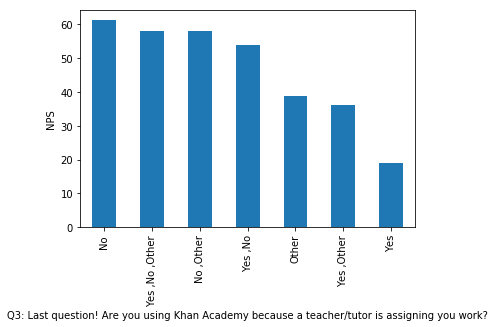

In [71]:
# Plot results of breakout by learner type
learner_type_table.sort_values("NPS", ascending=False, inplace=True)
learner_type_table.set_index(["Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?"]).NPS.plot.bar().set_ylabel("NPS")

So, it does look like these students have lower NPS relative to their self-declared "independent" learner counterparts. Breaking out by wave corroborates this as well (below; only considering 'strict' answer to Q3).

In [72]:
# Make learner type tables for each wave
learner_type_table_w1 = wave_1.groupby(["Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?"]).agg({"Response ID": 'size', "NPS_vals": 'mean'}).rename(columns={"Response ID": '# of Responses','NPS_vals': 'NPS'}).reset_index()
learner_type_table_w2 = wave_2.groupby(["Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?"]).agg({"Response ID": 'size', "NPS_vals": 'mean'}).rename(columns={"Response ID": '# of Responses','NPS_vals': 'NPS'}).reset_index()

# Set indexes before joining Wave 1 results table with Wave 2 results table
learner_type_table_w1.set_index(["Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?"], inplace=True)
learner_type_table_w2.set_index(["Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?"], inplace=True)

# Join dataframes on respondent type
NPS_over_time_by_learner_type = learner_type_table_w1.join(learner_type_table_w2, how="right", rsuffix=" (Wave 2)", lsuffix=" (Wave 1)")
NPS_over_time_by_learner_type.sort_values(["NPS (Wave 1)", "NPS (Wave 2)"], ascending=False, inplace=True)
NPS_over_time_by_learner_type

,# of Responses (Wave 1),NPS (Wave 1),# of Responses (Wave 2),NPS (Wave 2)
Q3: Last question! Are you using Khan Academy because a teacher/tutor is assigning you work?,,,,
No,11463,64.782343,12696,58.845306
Other,3110,24.823151,2155,43.573086
Yes,9880,17.024291,17781,20.454418


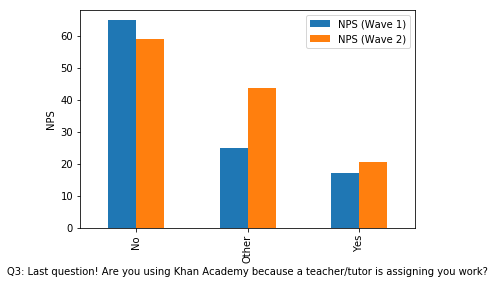

In [73]:
NPS_over_time_by_learner_type[["NPS (Wave 1)", "NPS (Wave 2)"]].plot.bar().set_ylabel("NPS")